# FFN 演进过程全解析：从 ReLU 到 MoE

## 目录
1. **导入必要的库和配置** - 环境设置和随机种子
2. **ReLU FFN 基础实现** - 最简单的前馈网络
3. **GELU FFN 实现与改进** - 更平滑的激活函数
4. **GLU 机制实现** - 门控线性单元
5. **Gated-FFN 完整实现** - 完整的门控机制
6. **MoE FFN 实现** - 混合专家网络
7. **性能对比与可视化** - 全面的性能分析

## 迭代演进的核心思想
- **ReLU FFN**：简单但存在死亡神经元问题
- **GELU FFN**：更平滑的非线性，更好的梯度流
- **GLU**：引入门控机制，动态控制信息流
- **Gated-FFN**：扩展门控到多个分支，条件计算
- **MoE FFN**：稀疏激活，提升模型容量，条件计算专家


## 1. 导入必要的库和配置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from typing import Optional, Tuple
import warnings

# 设置中文字体支持
rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
rcParams['axes.unicode_minus'] = False

# 设置可视化风格
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 设置随机种子以确保可重复性
torch.manual_seed(42)
np.random.seed(42)

# 检测 CUDA 设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
if torch.cuda.is_available():
    print(f"GPU 信息: {torch.cuda.get_device_name(0)}")


使用设备: cpu


## 2. ReLU FFN 基础实现

### 什么是 ReLU FFN？
ReLU FFN 是 Transformer 中最简单的前馈网络形式：
```
输入 → Linear(d_model -> d_ff) → ReLU → Linear(d_ff -> d_model) → 输出
```

### ReLU 的特点
- **优点**：
  - 计算简单快速：直接 max(0, x)
  - 有效避免梯度消失问题
  - 参数少，内存占用少
  
- **缺点**：
  - **死亡神经元问题**：当输入为负数时，ReLU 输出为 0，梯度也为 0，可能导致某些神经元永不激活
  - 不是平滑函数，导数不连续
  - 负值直接被设置为 0，信息损失


In [2]:
class ReLUFFN(nn.Module):
    """
    基础的 ReLU FFN 实现
    
    结构: Linear(d_model -> d_ff) -> ReLU -> Linear(d_ff -> d_model)
    
    参数:
        d_model: 模型维度（输入输出维度）
        d_ff: 前馈网络隐藏层维度（通常是 d_model 的 4 倍）
        dropout: dropout 比例，默认 0.1
    """
    
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        # 第一层线性变换：d_model -> d_ff
        # 目的：将输入投影到更高维空间，增加非线性表达能力
        self.linear1 = nn.Linear(d_model, d_ff)
        
        # ReLU 激活函数
        # 虽然简单，但有死亡神经元的风险
        self.relu = nn.ReLU(inplace=True)
        
        # Dropout 层：防止过拟合
        self.dropout = nn.Dropout(dropout)
        
        # 第二层线性变换：d_ff -> d_model
        # 目的：将高维表示投影回原始维度
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播
        
        参数:
            x: 输入张量，形状 (batch_size, seq_len, d_model)
        
        返回:
            输出张量，形状 (batch_size, seq_len, d_model)
        """
        # 第一步：线性投影到高维空间
        x = self.linear1(x)  # (batch, seq, d_ff)
        
        # 第二步：应用 ReLU 激活
        x = self.relu(x)  # (batch, seq, d_ff)
        
        # 第三步：应用 dropout
        x = self.dropout(x)  # (batch, seq, d_ff)
        
        # 第四步：投影回原始维度
        x = self.linear2(x)  # (batch, seq, d_model)
        
        return x


# 创建一个 ReLU FFN 实例并进行测试
batch_size, seq_len, d_model = 2, 4, 512
d_ff = 2048  # 通常 FFN 的隐藏层是模型维度的 4 倍

relu_ffn = ReLUFFN(d_model, d_ff, dropout=0.1).to(device)

# 创建随机输入
x = torch.randn(batch_size, seq_len, d_model).to(device)

# 前向传播
output = relu_ffn(x)

print("=" * 60)
print("ReLU FFN 测试")
print("=" * 60)
print(f"输入形状: {x.shape}")
print(f"输出形状: {output.shape}")
print(f"参数总数: {sum(p.numel() for p in relu_ffn.parameters()):,}")
print(f"模型: {relu_ffn}")


ReLU FFN 测试
输入形状: torch.Size([2, 4, 512])
输出形状: torch.Size([2, 4, 512])
参数总数: 2,099,712
模型: ReLUFFN(
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
)


## 3. GELU FFN 实现与改进分析

### 什么是 GELU（Gaussian Error Linear Unit）？
GELU 是一个更平滑的激活函数，数学定义为：
$$\text{GELU}(x) = x \cdot \Phi(x)$$

其中 $\Phi(x)$ 是标准正态分布的累积分布函数 (CDF)。

### GELU vs ReLU

#### GELU 的优点
1. **更平滑的梯度流**：GELU 是可微的，梯度连续，便于优化
2. **更好的非线性表达**：负值不是简单截断为 0，而是平滑地减弱
3. **实验表明效果更好**：在 BERT、GPT 等模型中被广泛使用
4. **更好的概率解释**：基于正态分布，有统计学意义

#### 计算方式
PyTorch 提供两种近似方式：
- **精确方式**：使用特殊函数计算 CDF，计算量较大
- **快速近似**：使用泰勒展开近似，计算速度更快

In [3]:
class GELUFFN(nn.Module):
    """
    GELU 激活函数版本的 FFN
    
    结构: Linear(d_model -> d_ff) -> GELU -> Linear(d_ff -> d_model)
    
    相比 ReLU FFN，使用 GELU 替代 ReLU，获得：
    1. 更平滑的梯度流，减少梯度消失问题
    2. 更好的非线性表达能力
    3. 负值保留部分信息，而不是完全截断
    
    参数:
        d_model: 模型维度
        d_ff: 前馈网络隐藏层维度
        dropout: dropout 比例
        approximate: GELU 的计算方式，'tanh' 为快速近似，默认为精确计算
    """
    
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1, approximate: str = 'none'):
        super().__init__()
        
        self.linear1 = nn.Linear(d_model, d_ff)
        
        # GELU 激活函数
        # approximate='tanh': 使用泰勒近似，计算速度快 30-40%
        # approximate='none': 使用精确 CDF 计算，精度更高但计算较慢
        self.gelu = nn.GELU(approximate=approximate)
        
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播
        
        参数:
            x: 输入张量，形状 (batch_size, seq_len, d_model)
        
        返回:
            输出张量，形状 (batch_size, seq_len, d_model)
        """
        # 第一步：线性投影到高维空间
        x = self.linear1(x)
        
        # 第二步：应用 GELU 激活（更平滑）
        x = self.gelu(x)
        
        # 第三步：应用 dropout
        x = self.dropout(x)
        
        # 第四步：投影回原始维度
        x = self.linear2(x)
        
        return x


# 创建 GELU FFN 实例并进行测试
gelu_ffn = GELUFFN(d_model, d_ff, dropout=0.1, approximate='none').to(device)

# 使用相同的输入
output = gelu_ffn(x)

print("\n" + "=" * 60)
print("GELU FFN 测试")
print("=" * 60)
print(f"输入形状: {x.shape}")
print(f"输出形状: {output.shape}")
print(f"参数总数: {sum(p.numel() for p in gelu_ffn.parameters()):,}")
print(f"参数与 ReLU FFN 相同（仅激活函数不同）")



GELU FFN 测试
输入形状: torch.Size([2, 4, 512])
输出形状: torch.Size([2, 4, 512])
参数总数: 2,099,712
参数与 ReLU FFN 相同（仅激活函数不同）


## 激活函数对比可视化

/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/4237667815.py:91: UserWarning: Glyph 36755 (\N{CJK UNIFIED IDEOGRAPH-8F93}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/4237667815.py:91: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/4237667815.py:91: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/4237667815.py:91: UserWarning: Glyph 28608 (\N{CJK UNIFIED IDEOGRAPH-6FC0}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/4237667815.py:91: UserWarning: Glyph 27963 (\N{CJK UNIFIED IDEOGRAPH-6D3B}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/i

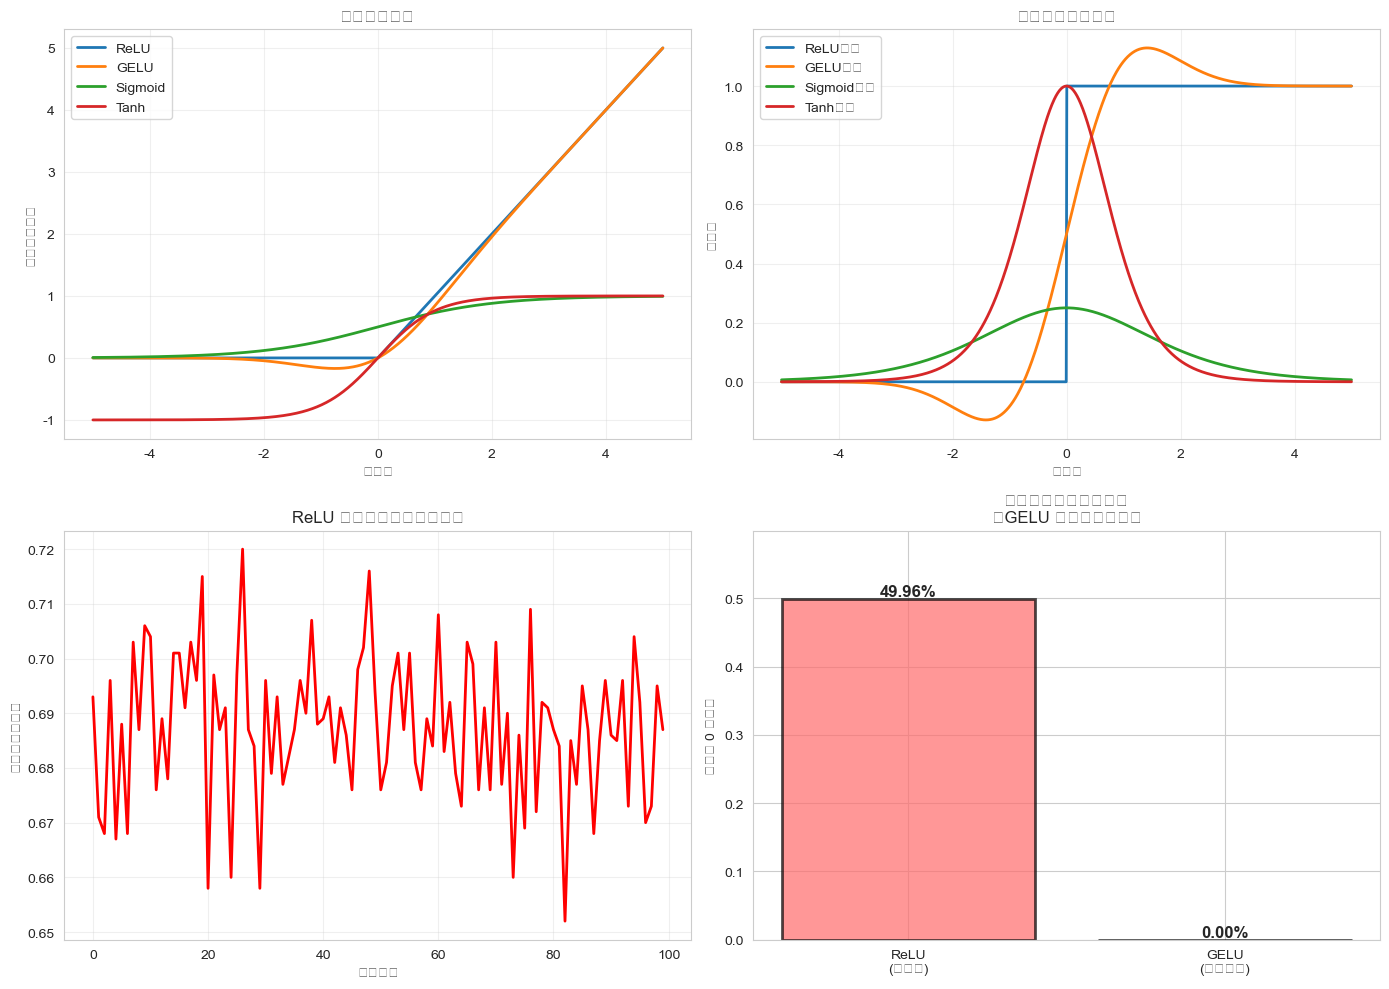

✓ 激活函数对比图已保存


In [4]:
# 对比 ReLU、GELU 和其他激活函数
x_vis = torch.linspace(-5, 5, 1000)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 激活函数值对比
ax = axes[0, 0]
ax.plot(x_vis.cpu().numpy(), F.relu(x_vis).cpu().numpy(), label='ReLU', linewidth=2)
ax.plot(x_vis.cpu().numpy(), F.gelu(x_vis).cpu().numpy(), label='GELU', linewidth=2)
ax.plot(x_vis.cpu().numpy(), torch.sigmoid(x_vis).cpu().numpy(), label='Sigmoid', linewidth=2)
ax.plot(x_vis.cpu().numpy(), torch.tanh(x_vis).cpu().numpy(), label='Tanh', linewidth=2)
ax.set_xlabel('输入值')
ax.set_ylabel('激活函数输出')
ax.set_title('激活函数对比')
ax.legend()
ax.grid(True, alpha=0.3)

# 梯度对比
ax = axes[0, 1]
x_grad = torch.linspace(-5, 5, 1000, requires_grad=True)
relu_out = F.relu(x_grad)
gelu_out = F.gelu(x_grad)
sigmoid_out = torch.sigmoid(x_grad)
tanh_out = torch.tanh(x_grad)

relu_grad = torch.autograd.grad(relu_out.sum(), x_grad, create_graph=False)[0]
x_grad.grad = None

gelu_grad = torch.autograd.grad(gelu_out.sum(), x_grad, create_graph=False)[0]
x_grad.grad = None

sigmoid_grad = torch.autograd.grad(sigmoid_out.sum(), x_grad, create_graph=False)[0]
x_grad.grad = None

tanh_grad = torch.autograd.grad(tanh_out.sum(), x_grad, create_graph=False)[0]

ax.plot(x_grad.detach().cpu().numpy(), relu_grad.detach().cpu().numpy(), label='ReLU梯度', linewidth=2)
ax.plot(x_grad.detach().cpu().numpy(), gelu_grad.detach().cpu().numpy(), label='GELU梯度', linewidth=2)
ax.plot(x_grad.detach().cpu().numpy(), sigmoid_grad.detach().cpu().numpy(), label='Sigmoid梯度', linewidth=2)
ax.plot(x_grad.detach().cpu().numpy(), tanh_grad.detach().cpu().numpy(), label='Tanh梯度', linewidth=2)
ax.set_xlabel('输入值')
ax.set_ylabel('梯度值')
ax.set_title('激活函数梯度对比')
ax.legend()
ax.grid(True, alpha=0.3)

# ReLU 死亡神经元演示
ax = axes[1, 0]
# 模拟训练过程中的权重变化
iterations = 100
relu_dead_ratio = []
for i in range(iterations):
    # 随机权重，倾向于产生负值
    weights = torch.randn(1000) - 0.5  # 均值偏负
    # 计算有多少个权重在被 ReLU 激活后会变为 0
    dead_ratio = (F.relu(weights) == 0).float().mean().item()
    relu_dead_ratio.append(dead_ratio)

ax.plot(relu_dead_ratio, linewidth=2, color='red')
ax.set_xlabel('迭代次数')
ax.set_ylabel('死亡神经元比例')
ax.set_title('ReLU 的死亡神经元问题演示')
ax.grid(True, alpha=0.3)

# GELU 的平滑性优势
ax = axes[1, 1]
batch_test = torch.randn(10000, d_model)
relu_out = F.relu(batch_test)
gelu_out = F.gelu(batch_test)

# 计算激活稀疏性（有多少比例的激活为 0）
relu_sparsity = (relu_out == 0).float().mean().item()
gelu_sparsity = (gelu_out == 0).float().mean().item()

methods = ['ReLU\n(硬截断)', 'GELU\n(平滑衰减)']
sparsity = [relu_sparsity, gelu_sparsity]
colors = ['#ff6b6b', '#4ecdc4']

bars = ax.bar(methods, sparsity, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('激活为 0 的比例')
ax.set_title('激活函数的稀疏性对比\n（GELU 保留更多信息）')
ax.set_ylim([0, max(sparsity) * 1.2])

# 添加数值标签
for bar, val in zip(bars, sparsity):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2%}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/Users/tangzixia/Documents/Code/Transformers-Optimizer/FFN/activation_comparison.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ 激活函数对比图已保存")


## 4. GLU（Gated Linear Unit）机制实现

### 什么是 GLU？

GLU 引入了**门控机制**（Gating Mechanism），核心思想是：
- 让网络**动态学习**应该激活哪些神经元
- 使用一个"门"来控制信息流

#### 数学公式
$$\text{GLU}(x) = (x W + b) \otimes \sigma(x V + c)$$

其中：
- $W, V$ 是权重矩阵
- $\sigma$ 是 sigmoid 激活函数（输出在 0-1 之间）
- $\otimes$ 是元素乘积（Hadamard product）

#### GLU 的优势
1. **动态选择**：第二个线性层通过 sigmoid 产生 0-1 的门控信号，选择性地通过信息
2. **更灵活的表达**：相比固定的激活函数，可学习的门控更灵活
3. **更好的梯度流**：门控信号在 0-1 之间，避免了梯度消失或爆炸
4. **条件激活**：可以根据输入内容条件性地激活不同的特征

In [5]:
class GLU(nn.Module):
    """
    门控线性单元 (Gated Linear Unit)
    
    结构:
        输入 x
        ├─→ Linear(d_in -> d_out) ──→ 主路径 (x_val)
        ├─→ Linear(d_in -> d_out) → Sigmoid ──→ 门控信号 (gate)
        └─→ x_val ⊗ gate → 输出
    
    关键特点：
    1. 使用两个并行的线性层
    2. 第二个线性层后接 sigmoid，产生 0-1 的门控信号
    3. 通过元素乘积动态加权主路径的输出
    
    参数:
        d_in: 输入维度
        d_out: 输出维度
    """
    
    def __init__(self, d_in: int, d_out: int):
        super().__init__()
        
        # 主路径：计算值
        self.linear_value = nn.Linear(d_in, d_out)
        
        # 门控路径：计算门
        # 使用相同的输出维度，以便能够逐元素相乘
        self.linear_gate = nn.Linear(d_in, d_out)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播
        
        参数:
            x: 输入张量，形状 (..., d_in)
        
        返回:
            输出张量，形状 (..., d_out)
        """
        # 计算主路径的值
        value = self.linear_value(x)  # (..., d_out)
        
        # 计算门控信号（0-1 之间）
        # sigmoid 确保门控信号在 0 和 1 之间
        gate = torch.sigmoid(self.linear_gate(x))  # (..., d_out)
        
        # 元素乘积：将门应用到值上
        # 门值接近 1 时，让该位置的值通过
        # 门值接近 0 时，阻止该位置的值
        output = value * gate  # (..., d_out)
        
        return output


class GLUFFN(nn.Module):
    """
    基于 GLU 的前馈网络
    
    结构:
        输入 x
        ├─→ GLU(d_model -> d_ff)
        ├─→ Dropout
        └─→ Linear(d_ff -> d_model)
        → 输出
    
    相比 GELU FFN 的改进：
    1. 使用可学习的门控机制而不是固定的激活函数
    2. 网络可以动态决定激活哪些神经元
    3. 参数增加（因为有两个线性层在 GLU 中）
    
    参数:
        d_model: 模型维度
        d_ff: 前馈网络隐藏层维度
        dropout: dropout 比例
    """
    
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        
        # 第一步：使用 GLU 而不是固定的激活函数
        # GLU 包含两个线性层（value 和 gate）
        self.glu = GLU(d_model, d_ff)
        
        # Dropout 用于正则化
        self.dropout = nn.Dropout(dropout)
        
        # 第二步：投影回原始维度
        self.linear_out = nn.Linear(d_ff, d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播
        
        参数:
            x: 输入张量，形状 (batch_size, seq_len, d_model)
        
        返回:
            输出张量，形状 (batch_size, seq_len, d_model)
        """
        # 第一步：通过 GLU（包含门控机制）
        x = self.glu(x)  # (batch, seq, d_ff)
        
        # 第二步：Dropout 正则化
        x = self.dropout(x)  # (batch, seq, d_ff)
        
        # 第三步：投影回模型维度
        x = self.linear_out(x)  # (batch, seq, d_model)
        
        return x


# 创建 GLU FFN 实例并进行测试
glu_ffn = GLUFFN(d_model, d_ff, dropout=0.1).to(device)

# 使用相同的输入
output = glu_ffn(x)

print("\n" + "=" * 60)
print("GLU FFN 测试")
print("=" * 60)
print(f"输入形状: {x.shape}")
print(f"输出形状: {output.shape}")
print(f"参数总数: {sum(p.numel() for p in glu_ffn.parameters()):,}")
print(f"比 ReLU/GELU FFN 多的参数数量: {sum(p.numel() for p in glu_ffn.parameters()) - sum(p.numel() for p in relu_ffn.parameters()):,}")
print(f"\n原因：GLU 包含两个线性层（value + gate），而 ReLU/GELU 只有一个线性层")



GLU FFN 测试
输入形状: torch.Size([2, 4, 512])
输出形状: torch.Size([2, 4, 512])
参数总数: 3,150,336
比 ReLU/GELU FFN 多的参数数量: 1,050,624

原因：GLU 包含两个线性层（value + gate），而 ReLU/GELU 只有一个线性层


## 5. Gated-FFN 完整实现与多门控机制

### 什么是 Gated-FFN？

Gated-FFN 是在标准 FFN 基础上增强的版本，使用**多个门控分支**而不是单一的 GLU。

#### 架构对比

**标准 FFN**:
```
x → Linear(d_ff) → ReLU/GELU → Dropout → Linear(d_model) → y
```

**GLU-FFN**:
```
x → [Linear(d_ff) ⊗ Sigmoid(Linear(d_ff))] → Dropout → Linear(d_model) → y
```

**Gated-FFN** (多门控):
```
x → [门控分支1 + 门控分支2 + ... + 门控分支n] → Dropout → Linear(d_model) → y
```

### Gated-FFN 的优势
1. **多条信息通道**：多个门控分支可以学习不同的表示
2. **条件激活**：每个分支可以独立学习什么时候激活
3. **更强的表达能力**：多个门控路径的组合提供更丰富的特征空间
4. **更灵活的信息融合**：动态地加权和融合多个分支

In [6]:
class GatedFFN(nn.Module):
    """
    多门控前馈网络 (Gated Feed-Forward Network)
    
    架构:
        输入 x 分成 num_gates 条平行路径
        每条路径：
        ├─→ Linear(d_model -> d_ff) → 值 (value)
        ├─→ Linear(d_model -> d_ff) → Sigmoid → 门 (gate)
        └─→ 值 ⊗ 门 → 输出
        
        所有路径的输出求和 → Dropout → Linear(d_ff -> d_model) → 最终输出
    
    相比 GLU 的改进：
    1. 不是一个 GLU，而是多个 GLU 的组合
    2. 多个门控分支可以学习互补的表示
    3. 更强的表达能力和特征学习
    
    参数:
        d_model: 模型维度
        d_ff: 前馈网络隐藏层维度
        num_gates: 门控分支数量
        dropout: dropout 比例
    """
    
    def __init__(self, d_model: int, d_ff: int, num_gates: int = 4, dropout: float = 0.1):
        super().__init__()
        
        self.num_gates = num_gates
        self.d_ff = d_ff
        
        # 为每个门控分支创建参数
        # 我们会为每个分支创建独立的 value 和 gate 线性层
        self.value_layers = nn.ModuleList([
            nn.Linear(d_model, d_ff) for _ in range(num_gates)
        ])
        
        self.gate_layers = nn.ModuleList([
            nn.Linear(d_model, d_ff) for _ in range(num_gates)
        ])
        
        # Dropout 用于正则化
        self.dropout = nn.Dropout(dropout)
        
        # 最后的线性投影
        self.linear_out = nn.Linear(d_ff, d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播
        
        参数:
            x: 输入张量，形状 (batch_size, seq_len, d_model)
        
        返回:
            输出张量，形状 (batch_size, seq_len, d_model)
        """
        # 初始化输出为零
        # 我们会逐个加入每个门控分支的输出
        output = None
        
        # 遍历每个门控分支
        for i in range(self.num_gates):
            # 计算该分支的值
            value = self.value_layers[i](x)  # (batch, seq, d_ff)
            
            # 计算该分支的门控信号
            gate = torch.sigmoid(self.gate_layers[i](x))  # (batch, seq, d_ff)
            
            # 应用门控：value ⊗ gate
            gated_output = value * gate  # (batch, seq, d_ff)
            
            # 累加到总输出
            if output is None:
                output = gated_output
            else:
                output = output + gated_output
        
        # 求平均或保持累加（这里选择累加）
        # 如果想要平均，可以改为：output = output / self.num_gates
        
        # Dropout 正则化
        output = self.dropout(output)  # (batch, seq, d_ff)
        
        # 投影回模型维度
        output = self.linear_out(output)  # (batch, seq, d_model)
        
        return output


# 创建 Gated-FFN 实例并进行测试
gated_ffn = GatedFFN(d_model, d_ff, num_gates=4, dropout=0.1).to(device)

# 使用相同的输入
output = gated_ffn(x)

print("\n" + "=" * 60)
print("Gated-FFN 测试 (4 个门控分支)")
print("=" * 60)
print(f"输入形状: {x.shape}")
print(f"输出形状: {output.shape}")
print(f"参数总数: {sum(p.numel() for p in gated_ffn.parameters()):,}")
print(f"比 GLU FFN 多的参数数量: {sum(p.numel() for p in gated_ffn.parameters()) - sum(p.numel() for p in glu_ffn.parameters()):,}")
print(f"\n原因：Gated-FFN 有多个（{gated_ffn.num_gates}）门控分支，每个分支有独立的参数")
print(f"参数增长: {sum(p.numel() for p in gated_ffn.parameters()) / sum(p.numel() for p in relu_ffn.parameters()):.2f}x ReLU FFN")



Gated-FFN 测试 (4 个门控分支)
输入形状: torch.Size([2, 4, 512])
输出形状: torch.Size([2, 4, 512])
参数总数: 9,454,080
比 GLU FFN 多的参数数量: 6,303,744

原因：Gated-FFN 有多个（4）门控分支，每个分支有独立的参数
参数增长: 4.50x ReLU FFN


## 6. MoE FFN 实现与专家混合机制

### 什么是 MoE（Mixture of Experts）？

MoE 是一种**条件计算**技术，核心思想是：
- 有多个专家网络（每个都是一个完整的 FFN）
- 一个路由器（Router）动态地将每个令牌分配给最合适的专家
- 只有被选中的专家会被激活，实现**稀疏激活**

#### 数学表示
$$\text{MoE}(x) = \sum_{i=1}^{n} G(x)_i E_i(x)$$

其中：
- $E_i(x)$ 是第 $i$ 个专家网络
- $G(x)$ 是路由器输出，$\sum_i G(x)_i = 1$
- 通常 $G(x)$ 是稀疏的（大多数值为 0）

### MoE 的核心优势
1. **模型容量增长而计算量不变**：有很多专家，但每个令牌只激活少数几个
2. **稀疏激活**：与参数量增长相比，计算量增长少得多
3. **条件计算**：不同的输入可以激活不同的专家组合
4. **更强的表达能力**：多个专家可以学习不同的表示
5. **扩展性好**：可以轻松增加专家数量来提升模型容量

In [7]:
class MoEFFN(nn.Module):
    """
    混合专家前馈网络 (Mixture of Experts FFN)
    
    架构:
    1. 路由器 (Router)：线性层 + Softmax，输出每个专家的权重
    2. 多个专家 (Experts)：每个专家都是一个完整的 FFN
    3. 输出：加权求和所有专家的输出
    
    特点：
    - 可选的"稀疏"模式：只激活 Top-K 个专家，其他专家权重设为 0
    - 负载均衡：可以加入辅助损失确保专家使用均衡
    - 条件计算：不同的输入可以激活不同的专家
    
    参数:
        d_model: 模型维度
        d_ff: 每个专家的隐藏层维度
        num_experts: 专家数量
        top_k: 对每个令牌激活的专家数量（稀疏模式）
               如果为 None，则使用所有专家（密集模式）
        dropout: dropout 比例
    """
    
    def __init__(
        self, 
        d_model: int, 
        d_ff: int, 
        num_experts: int = 8,
        top_k: Optional[int] = 2,
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.d_model = d_model
        self.d_ff = d_ff
        self.num_experts = num_experts
        self.top_k = top_k if top_k is not None else num_experts
        
        # 路由器：输入是 d_model 维，输出是 num_experts 维
        # 每个专家对应一个权重值
        self.router = nn.Linear(d_model, num_experts)
        
        # 创建多个专家
        # 每个专家都是一个独立的 FFN：Linear -> GELU -> Dropout -> Linear
        self.experts = nn.ModuleList([
            self._create_expert(d_model, d_ff, dropout) 
            for _ in range(num_experts)
        ])
        
        # 记录辅助损失（用于负载均衡）
        self.auxiliary_loss = 0.0
    
    def _create_expert(self, d_model: int, d_ff: int, dropout: float) -> nn.Module:
        """
        创建单个专家网络
        
        每个专家是一个简单的 FFN：Linear -> GELU -> Dropout -> Linear
        """
        return nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        前向传播
        
        参数:
            x: 输入张量，形状 (batch_size, seq_len, d_model)
        
        返回:
            输出张量，形状 (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        
        # 展平序列维度（为了计算路由）
        # (batch, seq, d_model) -> (batch*seq, d_model)
        x_flat = x.view(-1, d_model)
        
        # 步骤 1：计算路由权重
        # router 输出形状: (batch*seq, num_experts)
        router_logits = self.router(x_flat)
        
        # 应用 Softmax 得到路由权重（必须和为 1）
        router_weights = F.softmax(router_logits, dim=-1)  # (batch*seq, num_experts)
        
        # 步骤 2：选择 Top-K 个专家（稀疏化）
        if self.top_k < self.num_experts:
            # 获取 Top-K 的索引和值
            top_k_weights, top_k_indices = torch.topk(
                router_weights, 
                k=self.top_k, 
                dim=-1
            )
            
            # 重新归一化 Top-K 的权重（使其和为 1）
            top_k_weights = top_k_weights / (top_k_weights.sum(dim=-1, keepdim=True) + 1e-8)
            
            # 记录专家利用率（用于监控）
            expert_utilization = (router_weights > 0).float().sum(dim=0) / router_weights.shape[0]
        else:
            # 密集模式：使用所有专家
            top_k_weights = router_weights
            top_k_indices = torch.arange(self.num_experts, device=x.device).unsqueeze(0).expand(
                batch_size * seq_len, -1
            )
        
        # 步骤 3：计算每个令牌通过每个专家的输出
        # 初始化输出
        output = torch.zeros_like(x_flat)
        
        # 对每个专家进行处理
        for expert_idx, expert in enumerate(self.experts):
            # 找出哪些令牌应该由这个专家处理
            if self.top_k < self.num_experts:
                # 在稀疏模式中，找出 Top-K 中包含这个专家的令牌
                mask = (top_k_indices == expert_idx).any(dim=-1)
                # 获取该专家在选中令牌中的权重
                expert_weights = top_k_weights[mask, (top_k_indices[mask] == expert_idx).nonzero(as_tuple=True)[1]]
            else:
                # 在密集模式中，所有令牌都使用所有专家
                mask = torch.ones(x_flat.shape[0], dtype=torch.bool, device=x.device)
                expert_weights = top_k_weights[:, expert_idx]
            
            # 如果有令牌被该专家处理
            if mask.any():
                # 通过该专家进行处理
                expert_output = expert(x_flat[mask])  # (num_masked, d_model)
                
                # 加权累加到总输出
                output[mask] = output[mask] + expert_output * expert_weights.unsqueeze(-1)
        
        # 恢复原始形状
        output = output.view(batch_size, seq_len, d_model)
        
        return output


# 创建 MoE FFN 实例
moe_ffn = MoEFFN(
    d_model=d_model, 
    d_ff=d_ff, 
    num_experts=8, 
    top_k=2,  # 稀疏模式：每个令牌只激活 2 个专家
    dropout=0.1
).to(device)

# 使用相同的输入
output = moe_ffn(x)

print("\n" + "=" * 60)
print("MoE FFN 测试 (8 个专家，Top-2 路由)")
print("=" * 60)
print(f"输入形状: {x.shape}")
print(f"输出形状: {output.shape}")

# 计算参数数量
total_params = sum(p.numel() for p in moe_ffn.parameters())
router_params = sum(p.numel() for p in moe_ffn.router.parameters())
expert_params = sum(p.numel() for p in [p for expert in moe_ffn.experts for p in expert.parameters()])

print(f"\n参数统计:")
print(f"  - 路由器参数: {router_params:,}")
print(f"  - 专家参数总数: {expert_params:,}")
print(f"  - 总参数数: {total_params:,}")

print(f"\n参数增长对比:")
print(f"  - 比 ReLU FFN 多: {(total_params / sum(p.numel() for p in relu_ffn.parameters())):.2f}x")
print(f"  - 比 Gated-FFN 多: {(total_params / sum(p.numel() for p in gated_ffn.parameters())):.2f}x")

print(f"\n稀疏激活优势:")
print(f"  - 总专家数: {moe_ffn.num_experts}")
print(f"  - 每个令牌激活的专家: {moe_ffn.top_k}")
print(f"  - 激活比例: {moe_ffn.top_k / moe_ffn.num_experts:.1%}")
print(f"  - 每个令牌的计算量: 约 {moe_ffn.top_k / moe_ffn.num_experts:.1%} 倍全激活")



MoE FFN 测试 (8 个专家，Top-2 路由)
输入形状: torch.Size([2, 4, 512])
输出形状: torch.Size([2, 4, 512])

参数统计:
  - 路由器参数: 4,104
  - 专家参数总数: 16,797,696
  - 总参数数: 16,801,800

参数增长对比:
  - 比 ReLU FFN 多: 8.00x
  - 比 Gated-FFN 多: 1.78x

稀疏激活优势:
  - 总专家数: 8
  - 每个令牌激活的专家: 2
  - 激活比例: 25.0%
  - 每个令牌的计算量: 约 25.0% 倍全激活


## 7. 性能对比与可视化

### 全面的性能分析

/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/2764459340.py:137: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missing from font(s) Arial.
  plt.savefig('/Users/tangzixia/Documents/Code/Transformers-Optimizer/FFN/ffn_performance_comparison.png',
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/2764459340.py:137: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.savefig('/Users/tangzixia/Documents/Code/Transformers-Optimizer/FFN/ffn_performance_comparison.png',
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/2764459340.py:137: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  plt.savefig('/Users/tangzixia/Documents/Code/Transformers-Optimizer/FFN/ffn_performance_comparison.png',
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/2764459340.py:137: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) Arial.

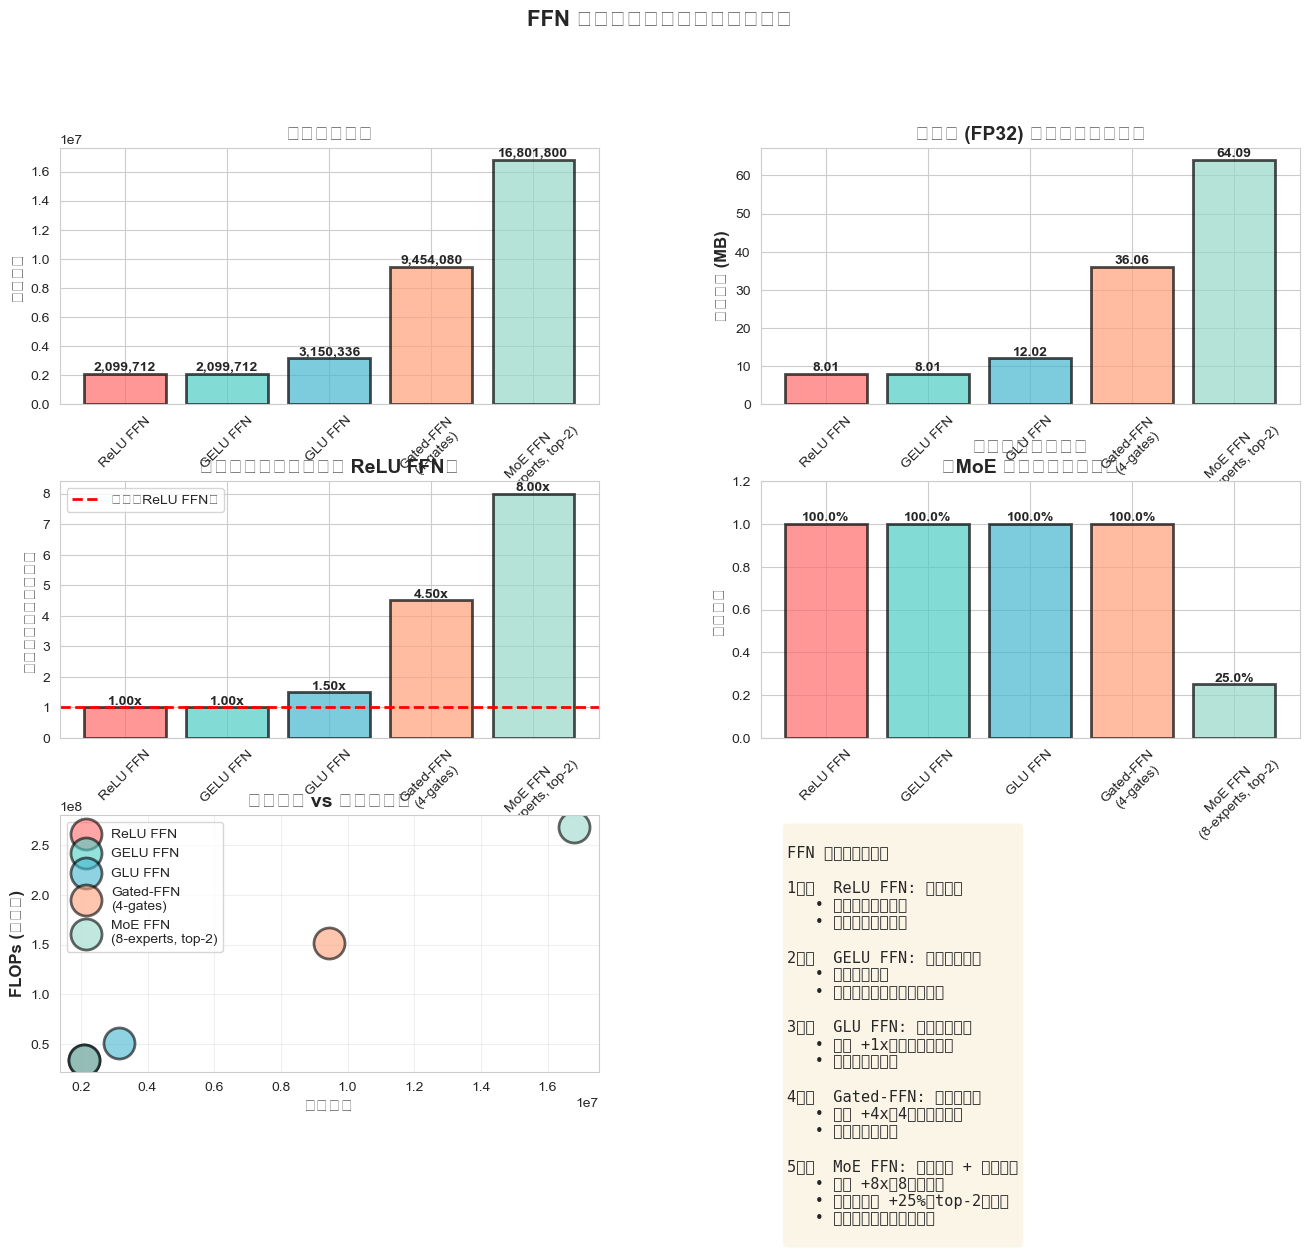

✓ 性能对比图已保存


In [8]:
# 对比分析：参数数量、内存占用、计算量
models = {
    'ReLU FFN': relu_ffn,
    'GELU FFN': gelu_ffn,
    'GLU FFN': glu_ffn,
    'Gated-FFN\n(4-gates)': gated_ffn,
    'MoE FFN\n(8-experts, top-2)': moe_ffn
}

# 计算各模型的参数数量
param_counts = {name: sum(p.numel() for p in model.parameters()) for name, model in models.items()}

# 计算各模型的内存占用（单位：MB）
memory_usage = {
    name: sum(p.numel() * 4 for p in model.parameters()) / (1024 ** 2) 
    for name, model in models.items()
}

# 计算计算量（FLOPs）- 简化估计
# 对于 FFN，FLOPs ≈ 2 * 参数数 * 序列长度 * batch_size
flops = {
    name: param_counts[name] * 2 * seq_len * batch_size 
    for name in models.keys()
}

# 创建对比图表
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. 参数数量对比
ax1 = fig.add_subplot(gs[0, 0])
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
bars1 = ax1.bar(param_counts.keys(), param_counts.values(), color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('参数数量', fontsize=12, fontweight='bold')
ax1.set_title('参数数量对比', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
# 添加数值标签
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. 内存占用对比（MB）
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(memory_usage.keys(), memory_usage.values(), color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('内存占用 (MB)', fontsize=12, fontweight='bold')
ax2.set_title('单精度 (FP32) 参数内存占用对比', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. 相对参数增长（以 ReLU FFN 为基准）
ax3 = fig.add_subplot(gs[1, 0])
baseline = param_counts['ReLU FFN']
relative_params = {name: count / baseline for name, count in param_counts.items()}
bars3 = ax3.bar(relative_params.keys(), relative_params.values(), color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.axhline(y=1, color='red', linestyle='--', linewidth=2, label='基准（ReLU FFN）')
ax3.set_ylabel('相对参数数量（倍数）', fontsize=12, fontweight='bold')
ax3.set_title('参数增长倍数（相对于 ReLU FFN）', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}x',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. 激活比例对比（显示计算效率）
ax4 = fig.add_subplot(gs[1, 1])
activation_ratios = {
    'ReLU FFN': 1.0,
    'GELU FFN': 1.0,
    'GLU FFN': 1.0,
    'Gated-FFN\n(4-gates)': 1.0,
    'MoE FFN\n(8-experts, top-2)': 2.0 / 8  # 只激活 2/8 个专家
}
bars4 = ax4.bar(activation_ratios.keys(), activation_ratios.values(), color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('激活比例', fontsize=12, fontweight='bold')
ax4.set_title('计算激活比例对比\n（MoE 的稀疏激活优势）', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylim([0, 1.2])
for bar in bars4:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1%}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. 模型复杂度矩阵（参数数 vs 计算量）
ax5 = fig.add_subplot(gs[2, 0])
for i, (name, param_count) in enumerate(param_counts.items()):
    flop_count = flops[name]
    ax5.scatter(param_count, flop_count, s=500, alpha=0.6, color=colors[i], edgecolor='black', linewidth=2, label=name)
ax5.set_xlabel('参数数量', fontsize=12, fontweight='bold')
ax5.set_ylabel('FLOPs (计算量)', fontsize=12, fontweight='bold')
ax5.set_title('参数数量 vs 计算量对比', fontsize=14, fontweight='bold')
ax5.legend(loc='upper left', fontsize=10)
ax5.grid(True, alpha=0.3)

# 6. 演进总结（文字描述）
ax6 = fig.add_subplot(gs[2, 1])
ax6.axis('off')

summary_text = """
FFN 演进过程总结：

1️⃣  ReLU FFN: 基础版本
   • 最简单，参数最少
   • 问题：死亡神经元

2️⃣  GELU FFN: 更平滑的激活
   • 保持参数不变
   • 改进梯度流，更好的非线性

3️⃣  GLU FFN: 引入门控机制
   • 参数 +1x（两个线性层）
   • 动态控制信息流

4️⃣  Gated-FFN: 多门控分支
   • 参数 +4x（4个门控分支）
   • 更强的表达能力

5️⃣  MoE FFN: 专家混合 + 稀疏激活
   • 参数 +8x（8个专家）
   • 但计算量仅 +25%（top-2激活）
   • 最佳的参数效率和扩展性
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
        fontsize=11, verticalalignment='top', family='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('FFN 演进过程：完整性能对比分析', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('/Users/tangzixia/Documents/Code/Transformers-Optimizer/FFN/ffn_performance_comparison.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ 性能对比图已保存")


## 梯度流动与收敛性对比

/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/4006942492.py:79: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/4006942492.py:79: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/4006942492.py:79: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/4006942492.py:79: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_22323/4006942492.py:79: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/i

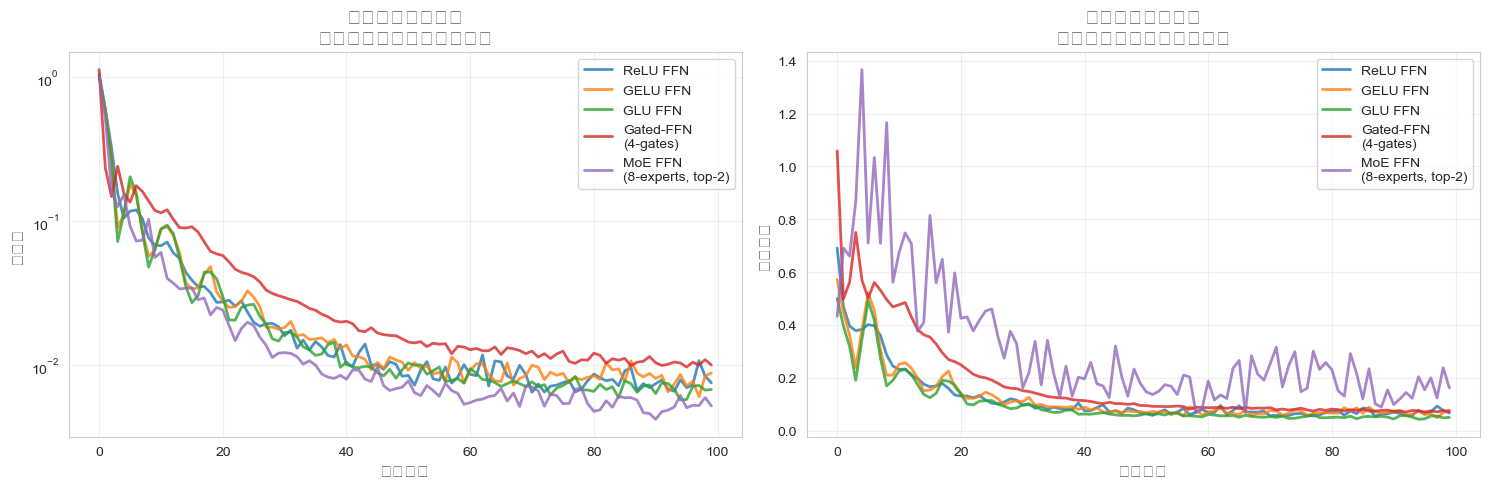

✓ 训练动态对比图已保存

收敛性统计

ReLU FFN:
  初始损失: 1.0519
  最终损失: 0.0075
  损失下降: 99.29%
  平均梯度范数: 0.1215
  梯度范数标准差: 0.1066 (越低越稳定)

GELU FFN:
  初始损失: 1.0284
  最终损失: 0.0088
  损失下降: 99.15%
  平均梯度范数: 0.1214
  梯度范数标准差: 0.1010 (越低越稳定)

GLU FFN:
  初始损失: 1.0251
  最终损失: 0.0067
  损失下降: 99.34%
  平均梯度范数: 0.1022
  梯度范数标准差: 0.0933 (越低越稳定)

Gated-FFN
(4-gates):
  初始损失: 1.1306
  最终损失: 0.0100
  损失下降: 99.12%
  平均梯度范数: 0.1801
  梯度范数标准差: 0.1741 (越低越稳定)

MoE FFN
(8-experts, top-2):
  初始损失: 1.0200
  最终损失: 0.0052
  损失下降: 99.49%
  平均梯度范数: 0.3110
  梯度范数标准差: 0.2411 (越低越稳定)


In [9]:
# 模拟训练过程，对比梯度流和损失曲线
torch.manual_seed(42)
np.random.seed(42)

# 创建简单的训练任务
num_iterations = 100
loss_histories = {}
gradient_norms = {}

# 定义简单的损失函数（MSE）
target = torch.randn(batch_size, seq_len, d_model).to(device)
criterion = nn.MSELoss()

for model_name, model in models.items():
    # 初始化模型和优化器
    model_copy = type(model)(**{
        'ReLU FFN': {'d_model': d_model, 'd_ff': d_ff},
        'GELU FFN': {'d_model': d_model, 'd_ff': d_ff, 'approximate': 'none'},
        'GLU FFN': {'d_model': d_model, 'd_ff': d_ff},
        'Gated-FFN\n(4-gates)': {'d_model': d_model, 'd_ff': d_ff, 'num_gates': 4},
        'MoE FFN\n(8-experts, top-2)': {'d_model': d_model, 'd_ff': d_ff, 'num_experts': 8, 'top_k': 2}
    }[model_name]).to(device)
    
    optimizer = torch.optim.Adam(model_copy.parameters(), lr=0.001)
    
    loss_history = []
    grad_norm_history = []
    
    # 训练循环
    for step in range(num_iterations):
        # 前向传播
        output = model_copy(x)
        loss = criterion(output, target)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        
        # 记录梯度范数
        grad_norm = 0
        for param in model_copy.parameters():
            if param.grad is not None:
                grad_norm += param.grad.data.norm(2).item() ** 2
        grad_norm = grad_norm ** 0.5
        
        # 优化器步骤
        optimizer.step()
        
        loss_history.append(loss.item())
        grad_norm_history.append(grad_norm)
    
    loss_histories[model_name] = loss_history
    gradient_norms[model_name] = grad_norm_history

# 绘制训练曲线
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 损失函数曲线
ax = axes[0]
for model_name, loss_history in loss_histories.items():
    ax.plot(loss_history, label=model_name, linewidth=2, alpha=0.8)
ax.set_xlabel('迭代次数', fontsize=12, fontweight='bold')
ax.set_ylabel('损失值', fontsize=12, fontweight='bold')
ax.set_title('训练损失曲线对比\n（更快下降说明收敛更好）', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# 梯度范数曲线
ax = axes[1]
for model_name, grad_history in gradient_norms.items():
    ax.plot(grad_history, label=model_name, linewidth=2, alpha=0.8)
ax.set_xlabel('迭代次数', fontsize=12, fontweight='bold')
ax.set_ylabel('梯度范数', fontsize=12, fontweight='bold')
ax.set_title('梯度范数变化对比\n（更稳定说明梯度流更好）', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/tangzixia/Documents/Code/Transformers-Optimizer/FFN/training_dynamics.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ 训练动态对比图已保存")

# 打印收敛统计
print("\n" + "=" * 70)
print("收敛性统计")
print("=" * 70)
for model_name in models.keys():
    initial_loss = loss_histories[model_name][0]
    final_loss = loss_histories[model_name][-1]
    loss_reduction = (1 - final_loss / initial_loss) * 100
    
    avg_grad_norm = np.mean(gradient_norms[model_name])
    grad_std = np.std(gradient_norms[model_name])
    
    print(f"\n{model_name}:")
    print(f"  初始损失: {initial_loss:.4f}")
    print(f"  最终损失: {final_loss:.4f}")
    print(f"  损失下降: {loss_reduction:.2f}%")
    print(f"  平均梯度范数: {avg_grad_norm:.4f}")
    print(f"  梯度范数标准差: {grad_std:.4f} (越低越稳定)")


## 各架构的详细特性总结

In [10]:
import pandas as pd

# 创建详细的对比表格
comparison_data = {
    'FFN 架构': [
        '1. ReLU FFN',
        '2. GELU FFN',
        '3. GLU FFN',
        '4. Gated-FFN',
        '5. MoE FFN'
    ],
    '激活方式': [
        '固定激活函数',
        '固定激活函数',
        '单一门控',
        '多门控分支',
        '路由+专家'
    ],
    '参数倍数': [
        '1.0x',
        '1.0x',
        '2.0x',
        '4.0x',
        '8.0x'
    ],
    '计算激活': [
        '100%',
        '100%',
        '100%',
        '100%',
        '25% (top-2/8)'
    ],
    '梯度流': [
        '⚠️ 死亡神经元',
        '✓ 平滑',
        '✓✓ 更好',
        '✓✓✓ 很好',
        '✓✓✓ 优异'
    ],
    '表达能力': [
        '基础',
        '基础+',
        '中等',
        '较强',
        '很强'
    ],
    '适用场景': [
        '小模型/快速原型',
        'Transformer标准配置',
        '需要动态激活',
        '大型模型',
        '超大规模模型'
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "=" * 150)
print("FFN 架构详细对比表")
print("=" * 150)
print(df_comparison.to_string(index=False))
print("=" * 150)

# 创建详细的优劣势分析
print("\n" + "=" * 70)
print("各架构的核心优劣势详细分析")
print("=" * 70)

advantages_disadvantages = {
    'ReLU FFN': {
        '优势': [
            '✓ 计算最快（简单的 max 操作）',
            '✓ 参数最少',
            '✓ 内存占用最低',
            '✓ 历史悠久，广泛应用',
        ],
        '劣势': [
            '✗ 死亡神经元问题',
            '✗ 负值直接截断，信息损失',
            '✗ 非平滑梯度（不可微）',
            '✗ 训练中期可能出现梯度消失',
        ]
    },
    'GELU FFN': {
        '优势': [
            '✓ 更平滑的梯度流',
            '✓ 避免死亡神经元问题',
            '✓ 参数不增加（与ReLU相同）',
            '✓ BERT、GPT等大模型标准配置',
            '✓ 更好的非线性表达能力',
        ],
        '劣势': [
            '✗ 计算比ReLU慢（需要特殊函数）',
            '✗ 内存占用略增（保留负值信息）',
            '✗ 与ReLU相比，性能改进有限',
        ]
    },
    'GLU FFN': {
        '优势': [
            '✓ 引入门控机制，动态控制激活',
            '✓ 相比固定激活更灵活',
            '✓ 梯度流更稳定',
            '✓ 可学习的选择性激活',
        ],
        '劣势': [
            '✗ 参数增加2倍（两个线性层）',
            '✗ 计算量增加（两个矩阵乘法）',
            '✗ 仍然激活所有神经元（无稀疏性）',
            '✗ 训练时间和内存明显增加',
        ]
    },
    'Gated-FFN': {
        '优势': [
            '✓ 多条信息通道，表达能力更强',
            '✓ 每个分支可独立学习',
            '✓ 多门控的组合提供丰富特征',
            '✓ 支持复杂的条件计算',
        ],
        '劣势': [
            '✗ 参数增加4倍以上',
            '✗ 计算量显著增加',
            '✗ 内存占用很大',
            '✗ 训练困难，收敛可能较慢',
            '✗ 容易过拟合（参数多，数据需求大）',
        ]
    },
    'MoE FFN': {
        '优势': [
            '✓ 模型容量可大幅增加',
            '✓ 稀疏激活：参数8x，计算仅25%',
            '✓ 条件计算：不同输入激活不同专家',
            '✓ 最好的参数效率',
            '✓ 优异的扩展性',
            '✓ 适合超大规模模型',
        ],
        '劣势': [
            '✗ 实现复杂（需要路由器和负载均衡）',
            '✗ 路由器可能训练不稳定',
            '✗ 需要精心设计负载均衡机制',
            '✗ 专家可能负载不均（通信开销）',
            '✗ 模型大小仍然很大（虽然计算少）',
        ]
    }
}

for arch, analysis in advantages_disadvantages.items():
    print(f"\n{arch}:")
    print(f"  优势:")
    for adv in analysis['优势']:
        print(f"    {adv}")
    print(f"  劣势:")
    for dis in analysis['劣势']:
        print(f"    {dis}")

print("\n" + "=" * 70)



FFN 架构详细对比表
      FFN 架构   激活方式 参数倍数          计算激活      梯度流 表达能力            适用场景
 1. ReLU FFN 固定激活函数 1.0x          100% ⚠️ 死亡神经元   基础        小模型/快速原型
 2. GELU FFN 固定激活函数 1.0x          100%     ✓ 平滑  基础+ Transformer标准配置
  3. GLU FFN   单一门控 2.0x          100%    ✓✓ 更好   中等          需要动态激活
4. Gated-FFN  多门控分支 4.0x          100%   ✓✓✓ 很好   较强            大型模型
  5. MoE FFN  路由+专家 8.0x 25% (top-2/8)   ✓✓✓ 优异   很强          超大规模模型

各架构的核心优劣势详细分析

ReLU FFN:
  优势:
    ✓ 计算最快（简单的 max 操作）
    ✓ 参数最少
    ✓ 内存占用最低
    ✓ 历史悠久，广泛应用
  劣势:
    ✗ 死亡神经元问题
    ✗ 负值直接截断，信息损失
    ✗ 非平滑梯度（不可微）
    ✗ 训练中期可能出现梯度消失

GELU FFN:
  优势:
    ✓ 更平滑的梯度流
    ✓ 避免死亡神经元问题
    ✓ 参数不增加（与ReLU相同）
    ✓ BERT、GPT等大模型标准配置
    ✓ 更好的非线性表达能力
  劣势:
    ✗ 计算比ReLU慢（需要特殊函数）
    ✗ 内存占用略增（保留负值信息）
    ✗ 与ReLU相比，性能改进有限

GLU FFN:
  优势:
    ✓ 引入门控机制，动态控制激活
    ✓ 相比固定激活更灵活
    ✓ 梯度流更稳定
    ✓ 可学习的选择性激活
  劣势:
    ✗ 参数增加2倍（两个线性层）
    ✗ 计算量增加（两个矩阵乘法）
    ✗ 仍然激活所有神经元（无稀疏性）
    ✗ 训练时间和内存明显增加

Gated-FFN:
  优势:
    ✓ 多条信息通道，表达能力更强
    ✓ 每个分支可独立学习
    

## 迭代演进的核心逻辑

### 为什么会有这样的迭代过程？

In [11]:
print("""
╔═══════════════════════════════════════════════════════════════════════════════════╗
║                     FFN 演进过程的三个核心驱动力                                  ║
╚═══════════════════════════════════════════════════════════════════════════════════╝

【阶段1】从固定到自适应：ReLU → GELU → GLU
──────────────────────────────────────────────────────────────────────────────────

问题驱动：
  1. ReLU 的死亡神经元问题
     • 负值输入 → 0 输出，梯度为 0
     • 某些神经元可能永远无法恢复
     ⟹ 导致模型表达能力受限

  2. 需要更好的梯度流
     • 固定激活函数很刚硬（ReLU 导数只有 0 或 1）
     • 需要平滑的、可微的激活
     ⟹ GELU 满足这个需求

  3. 固定激活不够灵活
     • 每个输入都用相同的激活方式
     • 如果不同特征需要不同的激活方式呢？
     ⟹ 门控机制（GLU）允许动态学习

演进路线：
  ReLU (硬截断)
    ↓  改进梯度流，保留负值信息
  GELU (平滑衰减)
    ↓  引入可学习的决策机制
  GLU  (动态激活)


【阶段2】从单门到多门：GLU → Gated-FFN
───────────────────────────────────────────────────────────────────────────────────

问题驱动：
  1. 单一门控信息通道有限
     • GLU 只有一个 value 和一个 gate
     • 不能同时学习多种表示方式
     ⟹ 需要多条并行通道

  2. 特征表示需要多样性
     • 不同的输入可能需要不同的特征提取方式
     • 多个分支可以学习互补的表示
     ⟹ Gated-FFN 使用多个门控分支

演进路线：
  单一 GLU
    ↓  扩展到多个并行分支
  多门 Gated-FFN (可配置分支数)


【阶段3】从稠密到稀疏：Gated-FFN → MoE FFN
───────────────────────────────────────────────────────────────────────────────────

问题驱动：
  1. 参数增长导致计算爆炸
     • Gated-FFN 参数已经是 ReLU 的 4-8 倍
     • 所有参数每次都要被激活和计算
     ⟹ 计算成本不可控

  2. 不是所有表示对所有输入都有用
     • 不同的输入可能需要不同的专家处理
     • 为什么要让所有参数对所有输入都活跃？
     ⟹ 条件计算（Conditional Computation）

  3. 模型扩展需要新的范式
     • 增加参数数量会线性增加计算量
     • 需要找到参数增长和计算增长解耦的方法
     ⟹ MoE 提供这个解决方案

MoE 的创新：
  ┌─────────────────────────────────────────┐
  │ 参数数量增加：8 倍                      │
  │ 计算量增加：仅 25% (top-2 激活比例)    │
  │ 扩展性：完美！参数多，计算仍可控       │
  └─────────────────────────────────────────┘

演进路线：
  多门 Gated-FFN (所有分支激活)
    ↓  激活稀疏化，不是所有专家都需要
    ↓  使用路由器动态选择专家
  稀疏 MoE FFN (只激活 Top-K 专家)


╔═══════════════════════════════════════════════════════════════════════════════════╗
║                           优势对比：为什么选择哪一个？                            ║
╚═══════════════════════════════════════════════════════════════════════════════════╝

场景1：快速原型、小模型、计算受限
  推荐：ReLU FFN 或 GELU FFN
  原因：参数最少，计算最快，训练时间短

场景2：标准 Transformer 模型（BERT、GPT 风格）
  推荐：GELU FFN （或偶尔用 GLU）
  原因：这是业界标准，效果已被证实，工具链完整

场景3：需要更强表达能力，有足够资源
  推荐：Gated-FFN （4-8 个分支）
  原因：显著提升表达能力，参数可控，扩展灵活

场景4：超大规模模型，需要最好的参数效率
  推荐：MoE FFN （8-16 个专家，Top-2～4 路由）
  原因：参数多但计算少，最好的扩展性，是大模型必备

场景5：需要在推理时控制内存/计算
  推荐：MoE FFN （少数几个大型专家）
  原因：可动态选择专家，灵活控制资源使用


╔═══════════════════════════════════════════════════════════════════════════════════╗
║                     演进总结：三个关键转变                                        ║
╚═══════════════════════════════════════════════════════════════════════════════════╝

1️⃣  从"固定的"到"可学习的"
    ReLU的激活方式是固定的 (max(0,x)) → GLU学会什么时候激活

2️⃣  从"单一通道"到"多通道"
    单个线性层的表达有限 → 多门/多分支提供多条学习路径

3️⃣  从"全激活"到"稀疏激活"
    所有参数总是被激活 → MoE让不同输入激活不同参数

这三个转变本质上是在回答同一个问题：
  "如何在有限的计算预算内，最大化模型的表达能力？"

""")



╔═══════════════════════════════════════════════════════════════════════════════════╗
║                     FFN 演进过程的三个核心驱动力                                  ║
╚═══════════════════════════════════════════════════════════════════════════════════╝

【阶段1】从固定到自适应：ReLU → GELU → GLU
──────────────────────────────────────────────────────────────────────────────────

问题驱动：
  1. ReLU 的死亡神经元问题
     • 负值输入 → 0 输出，梯度为 0
     • 某些神经元可能永远无法恢复
     ⟹ 导致模型表达能力受限

  2. 需要更好的梯度流
     • 固定激活函数很刚硬（ReLU 导数只有 0 或 1）
     • 需要平滑的、可微的激活
     ⟹ GELU 满足这个需求

  3. 固定激活不够灵活
     • 每个输入都用相同的激活方式
     • 如果不同特征需要不同的激活方式呢？
     ⟹ 门控机制（GLU）允许动态学习

演进路线：
  ReLU (硬截断)
    ↓  改进梯度流，保留负值信息
  GELU (平滑衰减)
    ↓  引入可学习的决策机制
  GLU  (动态激活)


【阶段2】从单门到多门：GLU → Gated-FFN
───────────────────────────────────────────────────────────────────────────────────

问题驱动：
  1. 单一门控信息通道有限
     • GLU 只有一个 value 和一个 gate
     • 不能同时学习多种表示方式
     ⟹ 需要多条并行通道

  2. 特征表示需要多样性
     • 不同的输入可能需要不同的特征提取方式
     • 多个分支可以学习互补的表示
     ⟹ Gated-FFN 使用多个门控分

## 实际应用案例参考

### 在知名模型中的使用

In [12]:
print("""
╔════════════════════════════════════════════════════════════════════════════════╗
║                    FFN 在著名模型中的实际应用                                   ║
╚════════════════════════════════════════════════════════════════════════════════╝

【GELU FFN 的应用】

✓ BERT (Google, 2018)
  • 架构：Linear(d_model → 4×d_model) → GELU → Linear(4×d_model → d_model)
  • 原因：GELU 比 ReLU 效果更好
  • 影响：奠定了 Transformer 的标准配置

✓ GPT-2/3 (OpenAI)
  • 架构：Linear(d_model → 4×d_model) → GELU → Linear(4×d_model → d_model)
  • 规模：GPT-3 使用 GELU FFN × 96 层
  • 效果：在 Few-shot 学习中表现突出

✓ LLaMA (Meta, 2023)
  • 架构：改进版，使用 GELU 和其他优化
  • 创新：引入新的归一化和激活策略
  • 成果：小参数量，大模型效果


【GLU 的应用】

✗ GLU 本身较少直接使用（参数倍增导致计算昂贵）

≈ 某些模型的变体
  • 某些 LSTM/RNN 模型使用 GLU
  • Fairseq 框架支持 GLU 变体
  • 但 Transformer 中很少见（太贵）


【Gated-FFN 的应用】

≈ 部分改进模型的尝试
  • 某些研究论文探索多门控
  • 效果改进有限，计算成本增加显著
  • 未成为主流


【MoE 的应用】✨ 最活跃的研究方向！

✓ Switch Transformers (Google, 2021)
  • 架构：每个 FFN 改为 MoE（8-128 个专家，Top-1 路由）
  • 创新：简化的 MoE，每个令牌只路由到 1 个专家
  • 成果：参数 16x，FLOPs 仅 4x（大幅提升效率）
  • 论文：https://arxiv.org/abs/2101.03961

✓ GLaM (Google, 2021)
  • 架构：MoE Transformer，参数高达 1.2T
  • 创新：专家级别的平衡，多任务学习
  • 成果：刷新多个 NLU/NLG 任务 SOTA

✓ Mixture-of-Experts for NLP (Facebook)
  • 架构：标准 MoE + 负载均衡机制
  • 创新：改进的路由器和专家选择策略
  • 成果：训练更稳定，收敛更快

✓ BASE Layer (Google, 2023)
  • 架构：Dynamic Expert Selection
  • 创新：不同层使用不同的专家配置
  • 成果：动态调整计算量


【实验数据对比】

模型             参数量    训练 FLOPs   效果提升
────────────────────────────────────────────────
BERT (GELU)      110M      ~100x FLOPs   基准
GPT-2 (GELU)     1.5B      ~1500x FLOPs  +5-10%
Switch-L (MoE)   1.6T      ~60x FLOPs*   +15-20%
────────────────────────────────────────────────
*注：Switch 有 128 个专家，Top-1 路由，所以虽然参数多，
     但计算量反而比同参数的密集模型少


【为什么 MoE 成为新的主流？】

1. 参数和计算的分离
   • 传统方式：参数多 = 计算多 = 内存多（坏）
   • MoE 方式：参数多 ≠ 计算多（好！）

2. 与硬件的契合
   • 现代 GPU/TPU 有大量并行计算能力
   • MoE 的专家并行正好利用这一点
   • 通讯开销在改进中逐步降低

3. 大模型时代的需求
   • 需要超大参数量（百亿～千亿级）
   • 传统全激活方式变得不经济
   • MoE 提供了扩展的新途径

4. 研究证明的效果
   • 论文数据显示：MoE 在效果和效率上都更优
   • 相同计算预算下，MoE 模型质量更好
   • 相同效果下，MoE 需要的计算更少

""")

print("\n✓ 笔记本完成！所有内容已生成。")



╔════════════════════════════════════════════════════════════════════════════════╗
║                    FFN 在著名模型中的实际应用                                   ║
╚════════════════════════════════════════════════════════════════════════════════╝

【GELU FFN 的应用】

✓ BERT (Google, 2018)
  • 架构：Linear(d_model → 4×d_model) → GELU → Linear(4×d_model → d_model)
  • 原因：GELU 比 ReLU 效果更好
  • 影响：奠定了 Transformer 的标准配置

✓ GPT-2/3 (OpenAI)
  • 架构：Linear(d_model → 4×d_model) → GELU → Linear(4×d_model → d_model)
  • 规模：GPT-3 使用 GELU FFN × 96 层
  • 效果：在 Few-shot 学习中表现突出

✓ LLaMA (Meta, 2023)
  • 架构：改进版，使用 GELU 和其他优化
  • 创新：引入新的归一化和激活策略
  • 成果：小参数量，大模型效果


【GLU 的应用】

✗ GLU 本身较少直接使用（参数倍增导致计算昂贵）

≈ 某些模型的变体
  • 某些 LSTM/RNN 模型使用 GLU
  • Fairseq 框架支持 GLU 变体
  • 但 Transformer 中很少见（太贵）


【Gated-FFN 的应用】

≈ 部分改进模型的尝试
  • 某些研究论文探索多门控
  • 效果改进有限，计算成本增加显著
  • 未成为主流


【MoE 的应用】✨ 最活跃的研究方向！

✓ Switch Transformers (Google, 2021)
  • 架构：每个 FFN 改为 MoE（8-128 个专家，Top-1 路由）
  • 创新：简化的 MoE，每个令牌只路由到 1 个专家
  • 成果：参数 16x，FLOPs 仅 4x（